In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 14 01:08:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [126]:
#!pip install Keras-Preprocessing
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 922.4 kB/s eta 0:00:00


In [127]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import nltk
import re
import joblib
#import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter

from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

from textblob import Word

nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

re.compile('<title>(.*)</title>')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


re.compile(r'<title>(.*)</title>', re.UNICODE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/lnu-deep-learn-2-text-classification-2023.zip'
%ls

Archive:  /content/drive/MyDrive/lnu-deep-learn-2-text-classification-2023.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
drive/  sample_data/  sample_submission.csv  test.csv  train.csv


In [ ]:
%cd /content

/content


## Load dataset

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df

,text,humor,id
0,Watch this swimmer disappear into winter storm...,0,42e466fe04c94cd18c5be40fff1c4f97
1,"They laughed at reagan, too: trump's ideas wil...",0,7840c01d01964aa78641013566828c18
2,"Hey, are you cold? go over to the corner, it's...",1,ad018a0f4d5c4f2d919c7292ebb1547d
3,Can't get a standing desk? these are almost as...,0,89616f57313d43fcb7084ade6f709d57
4,Wanna hear a joke about my penis? never mind i...,1,5df9f888d78c45f094387e8ce1da018f
...,...,...,...
159995,I want to learn how to do 3 things before i di...,1,0c532972a90747f3907b260a9897e3b8
159996,Gabrielle union on the #metoo movement: 'the f...,0,ea99552a300f44b0af973b1ace5cda46
159997,"Deodorant: ugh i hate my job, gotta go in his ...",1,561674776f6f453f9b718fe792a383d5
159998,Harvard law professor to join the race for dem...,0,fe449d646e6044aaac3a9679fd0437a1


In [ ]:
df['humor'].value_counts()

0    80000
1    80000
Name: humor, dtype: int64

## Data cleaning

In [ ]:
df['text']=df['text'].fillna("")
df.isna().sum()

text     0
humor    0
id       0
dtype: int64

# Preprocessing

In [ ]:
df['lower_case'] = df['text'].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))

df['alphabatic'] = df['lower_case'].apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ', x)).apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
df['without-link'] = df['alphabatic'].apply(lambda x: re.sub(r'http\S+', '', x))

tokenizer = RegexpTokenizer(r'\w+')
df['Special_word'] = df.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)

stop = [word for word in stopwords.words('english') if word not in ["my","haven't","aren't","can","no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"]]

df['stop_words'] = df['Special_word'].apply(lambda x: [item for item in x if item not in stop])
df['stop_words'] = df['stop_words'].astype('str')

df['short_word'] = df['stop_words'].str.findall('\w{2,}')
df['string']=df['short_word'].str.join(' ')

df['Text'] = df['string'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
df

,text,humor,id,lower_case,alphabatic,without-link,Special_word,stop_words,short_word,string,Text
0,Watch this swimmer disappear into winter storm...,0,42e466fe04c94cd18c5be40fff1c4f97,watch this swimmer disappear into winter storm...,watch this swimmer disappear into winter storm...,watch this swimmer disappear into winter storm...,"[watch, this, swimmer, disappear, into, winter...","['watch', 'swimmer', 'disappear', 'winter', 's...","[watch, swimmer, disappear, winter, storm, jonas]",watch swimmer disappear winter storm jonas,watch swimmer disappear winter storm jonas
1,"They laughed at reagan, too: trump's ideas wil...",0,7840c01d01964aa78641013566828c18,"they laughed at reagan, too: trump's ideas wil...",they laughed at reagan too trump's ideas wil...,they laughed at reagan too trump's ideas wil...,"[they, laughed, at, reagan, too, trump, s, ide...","['laughed', 'reagan', 'trump', 'ideas', 'will'...","[laughed, reagan, trump, ideas, will, outlast,...",laughed reagan trump ideas will outlast politi...,laughed reagan trump idea will outlast politic...
2,"Hey, are you cold? go over to the corner, it's...",1,ad018a0f4d5c4f2d919c7292ebb1547d,"hey, are you cold? go over to the corner, it's...",hey are you cold go over to the corner it's...,hey are you cold go over to the corner it's...,"[hey, are, you, cold, go, over, to, the, corne...","['hey', 'you', 'cold', 'go', 'corner', '90', '...","[hey, you, cold, go, corner, 90, degress]",hey you cold go corner 90 degress,hey you cold go corner 90 degress
3,Can't get a standing desk? these are almost as...,0,89616f57313d43fcb7084ade6f709d57,can't get a standing desk? these are almost as...,can't get a standing desk these are almost as...,can't get a standing desk these are almost as...,"[can, t, get, a, standing, desk, these, are, a...","['can', 'get', 'standing', 'desk', 'almost', '...","[can, get, standing, desk, almost, good]",can get standing desk almost good,can get standing desk almost good
4,Wanna hear a joke about my penis? never mind i...,1,5df9f888d78c45f094387e8ce1da018f,wanna hear a joke about my penis? never mind i...,wanna hear a joke about my penis never mind i...,wanna hear a joke about my penis never mind i...,"[wanna, hear, a, joke, about, my, penis, never...","['wanna', 'hear', 'joke', 'my', 'penis', 'neve...","[wanna, hear, joke, my, penis, never, mind, long]",wanna hear joke my penis never mind long,wanna hear joke my penis never mind long
...,...,...,...,...,...,...,...,...,...,...,...
159995,I want to learn how to do 3 things before i di...,1,0c532972a90747f3907b260a9897e3b8,i want to learn how to do 3 things before i di...,i want to learn how to do things before i di...,i want to learn how to do things before i di...,"[i, want, to, learn, how, to, do, 3, things, b...","['want', 'learn', 'do', '3', 'things', 'die', ...","[want, learn, do, things, die, learn, count]",want learn do things die learn count,want learn do thing die learn count
159996,Gabrielle union on the #metoo movement: 'the f...,0,ea99552a300f44b0af973b1ace5cda46,gabrielle union on the #metoo movement: 'the f...,gabrielle union on the metoo movement 'the f...,gabrielle union on the metoo movement 'the f...,"[gabrielle, union, on, the, metoo, movement, t...","['gabrielle', 'union', 'metoo', 'movement', 'f...","[gabrielle, union, metoo, movement, floodgates...",gabrielle union metoo movement floodgates open...,gabrielle union metoo movement floodgate opene...
159997,"Deodorant: ugh i hate my job, gotta go in his ...",1,561674776f6f453f9b718fe792a383d5,"deodorant: ugh i hate my job, gotta go in his ...",deodorant ugh i hate my job gotta go in his ...,deodorant ugh i hate my job gotta go in his ...,"[deodorant, ugh, i, hate, my, job, gotta, go, ...","['deodorant', 'ugh', 'hate', 'my', 'job', 'got...","[deodorant, ugh, hate, my, job, gotta, go, gro...",deodorant ugh hate my job gotta go gross armpi...,deodorant ugh hate my job gotta go gross armpi...
159998,Harvard law professor to join the race for dem..

# Visualization

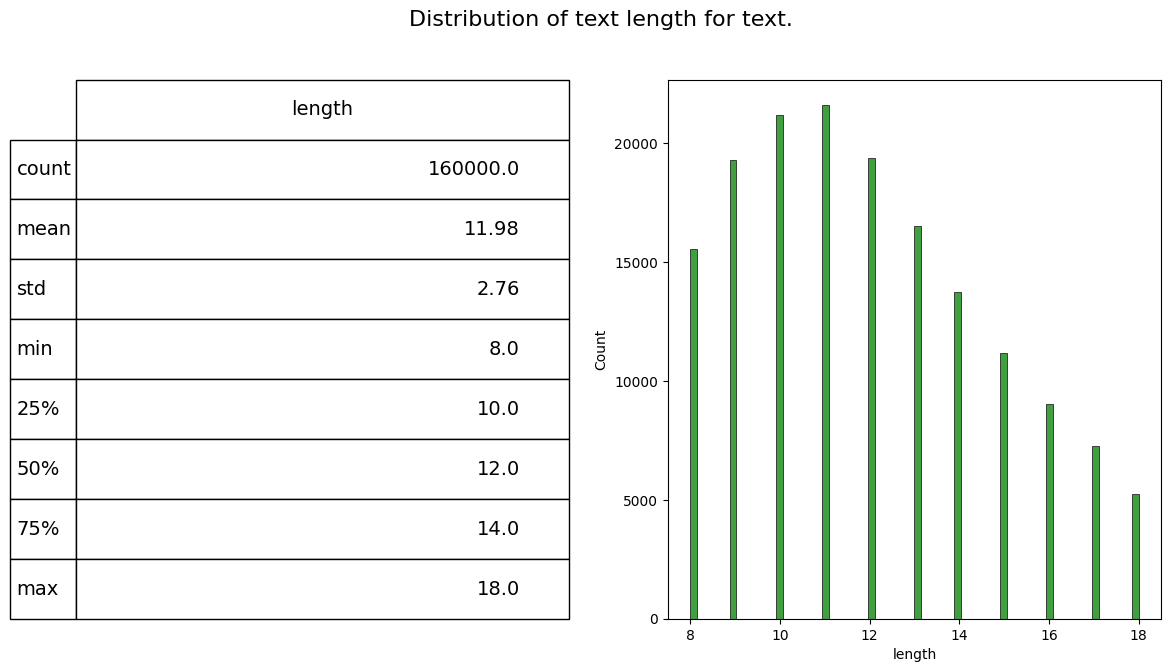

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df['length'], ax=ax1,color='green')
describe = df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for text.', fontsize=16)

plt.show()

<Axes: xlabel='humor', ylabel='count'>

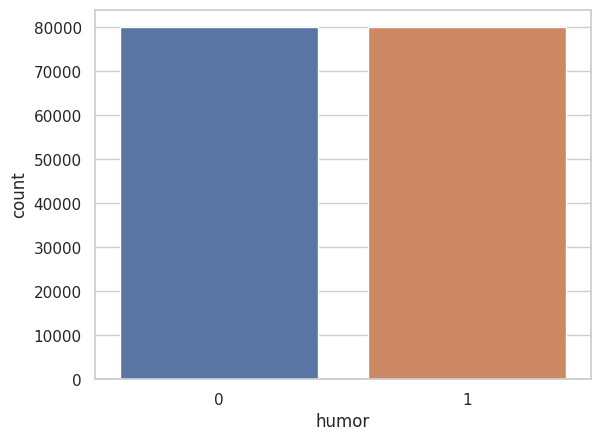

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df["humor"])

In [ ]:
top = Counter([item for sublist in df['short_word'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
serious_text = df[df['humor']==0]
humor_text = df[df['humor']==1]

In [ ]:
top = Counter([item for sublist in serious_text['short_word'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words in sport_text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
top = Counter([item for sublist in humor_text['short_word'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words in sport_text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

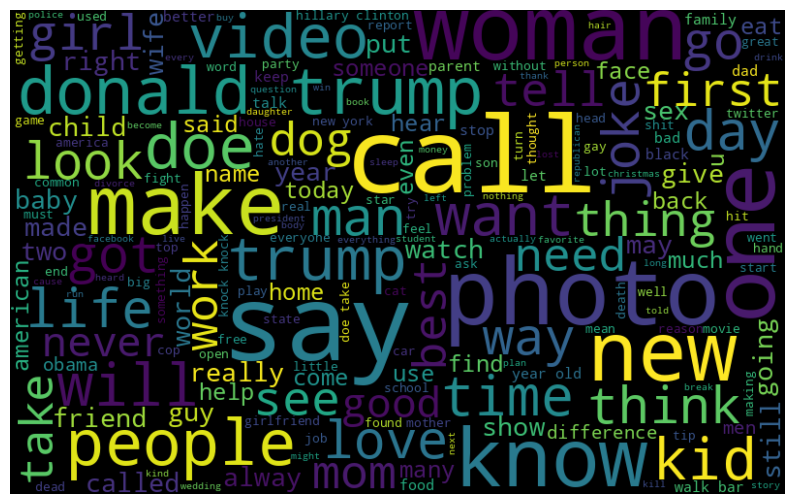

In [ ]:
normal_words =' '.join([text for text in df['Text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

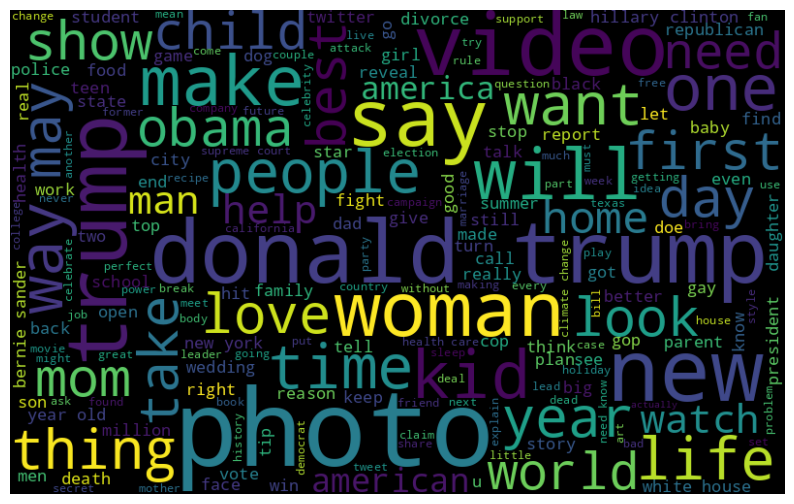

In [ ]:
normal_words =' '.join([text for text in df['Text'][df['humor'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

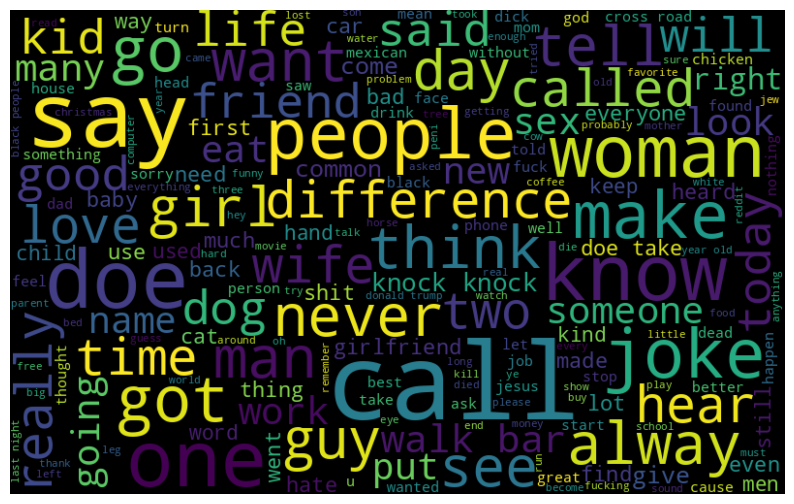

In [ ]:
normal_words =' '.join([text for text in df['Text'][df['humor'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [131]:
y = df.humor

In [133]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42, test_size=0.3)
classes = X_train.humor

In [132]:
def build_model(hyperparams):
    vocabulary = 1000

    encoder = tf.keras.layers.TextVectorization(
        max_tokens=vocabulary)
    encoder.adapt(X_train.text)

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=(1,), dtype="string"))

    model.add(encoder)

    model.add(tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True))

    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hyperparams.Int('LSTM_units', min_value=32, max_value=256, step=64, default=128))))

    model.add(tf.keras.layers.Dense(units=hyperparams.Int('dense_units', min_value=32, max_value=512, step=32, default=256),
                                    activation=hyperparams.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='sigmoid')))

    model.add(tf.keras.layers.Dense(1, activation=hyperparams.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='sigmoid')))

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(hyperparams.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='LOG', default=0.001)),
              metrics=['accuracy'])

    return model

In [137]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=3,
                     factor=3,
                     directory='my_dir2',
                     project_name='intro_to_kt2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train.text, classes, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 6 Complete [00h 02m 57s]
val_accuracy: 0.9198660850524902

Best val_accuracy So Far: 0.9391071200370789
Total elapsed time: 00h 14m 45s


In [138]:
print(f"LSTM units:{best_hyperparams.get('LSTM_units')}")
print(f"Learning rate:{best_hyperparams.get('learning_rate')}")
print(f"Dense units:{best_hyperparams.get('dense_units')}")
print(f"dense activation:{best_hyperparams.get('dense_activation')}")

LSTM units:224
Learning rate:0.002182626819790627
Dense units:64
dense activation:sigmoid


In [139]:
model = tuner.hypermodel.build(best_hyperparams)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirecti  (None, 448)               517888    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                28736     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 610689 (2.33 MB)
Trainable params: 61068

In [141]:
acc_per_fold = []
loss_per_fold = []
histories = []

inputs = np.concatenate((X_train.text, X_test.text), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

kfold = KFold(n_splits = 5, shuffle = True)

fold_number = 1
for train, test in kfold.split(inputs, targets):

  model = tuner.hypermodel.build(best_hyperparams)
  print("====================================")
  histories.append(model.fit(inputs[train], targets[train], epochs = 10,validation_split = 0.3))

  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Fold {fold_number}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])

  fold_number += 1

Epoch 1/10
2800/2800 [==============================] - 91s 28ms/step - loss: 0.2106 - accuracy: 0.9168 - val_loss: 0.1835 - val_accuracy: 0.9295
Epoch 2/10
2800/2800 [==============================] - 51s 18ms/step - loss: 0.1666 - accuracy: 0.9348 - val_loss: 0.1647 - val_accuracy: 0.9347
Epoch 3/10
2800/2800 [==============================] - 50s 18ms/step - loss: 0.1481 - accuracy: 0.9422 - val_loss: 0.1646 - val_accuracy: 0.9359
Epoch 4/10
2800/2800 [==============================] - 54s 19ms/step - loss: 0.1326 - accuracy: 0.9493 - val_loss: 0.1659 - val_accuracy: 0.9357
Epoch 5/10
2800/2800 [==============================] - 56s 20ms/step - loss: 0.1157 - accuracy: 0.9555 - val_loss: 0.1793 - val_accuracy: 0.9352
Epoch 6/10
2800/2800 [==============================] - 54s 19ms/step - loss: 0.0986 - accuracy: 0.9624 - val_loss: 0.1828 - val_accuracy: 0.9362
Epoch 7/10
2800/2800 [==============================] - 53s 19ms/step - loss: 0.0789 - accuracy: 0.9701 - val_loss: 0.2022 -

Fold:1: Accuracy: 0.9325000047683716 --- Loss: 0.24665090441703796
Fold:2: Accuracy: 0.9269687533378601 --- Loss: 0.25457465648651123
Fold:3: Accuracy: 0.9305312633514404 --- Loss: 0.25030094385147095
Fold:4: Accuracy: 0.9280312657356262 --- Loss: 0.27445802092552185
Fold:5: Accuracy: 0.9307500123977661 --- Loss: 0.24977518618106842


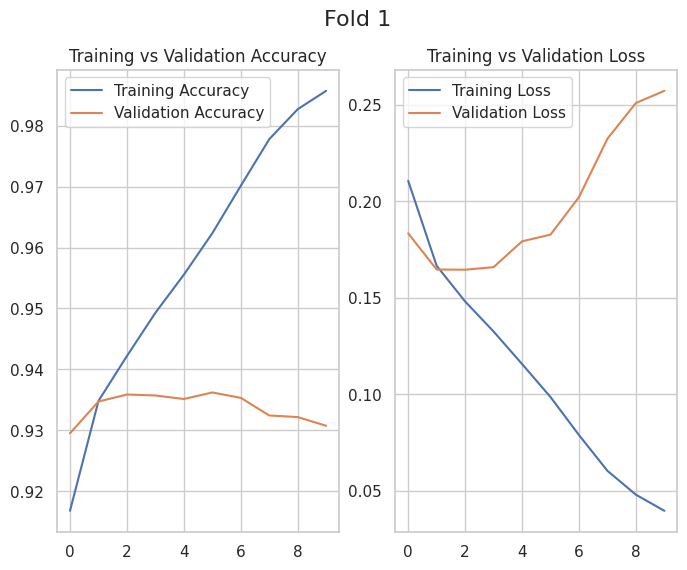

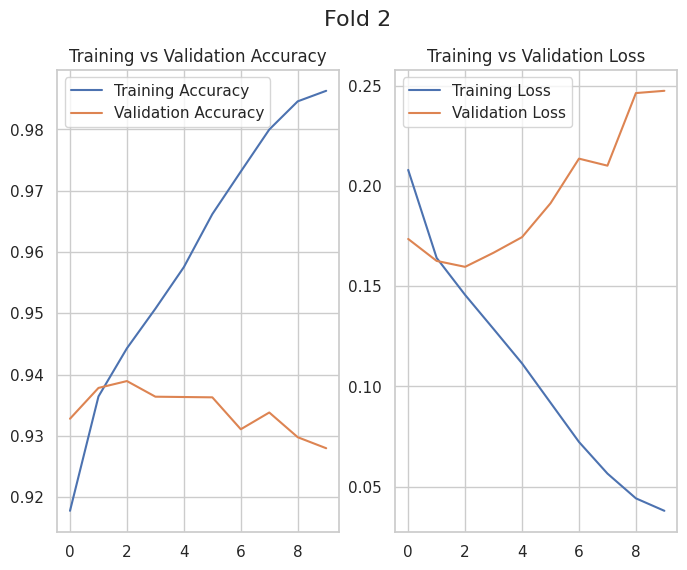

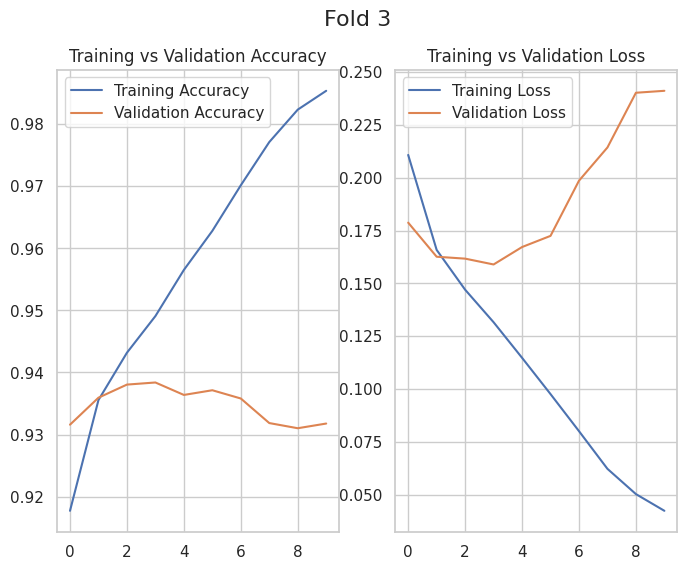

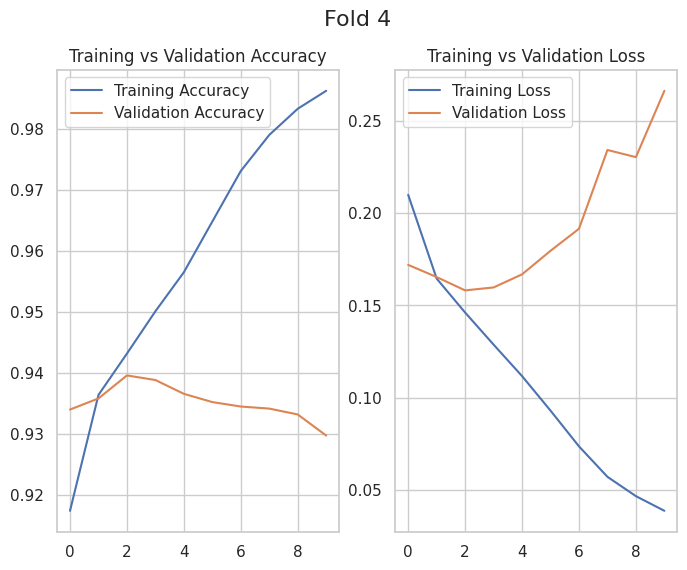

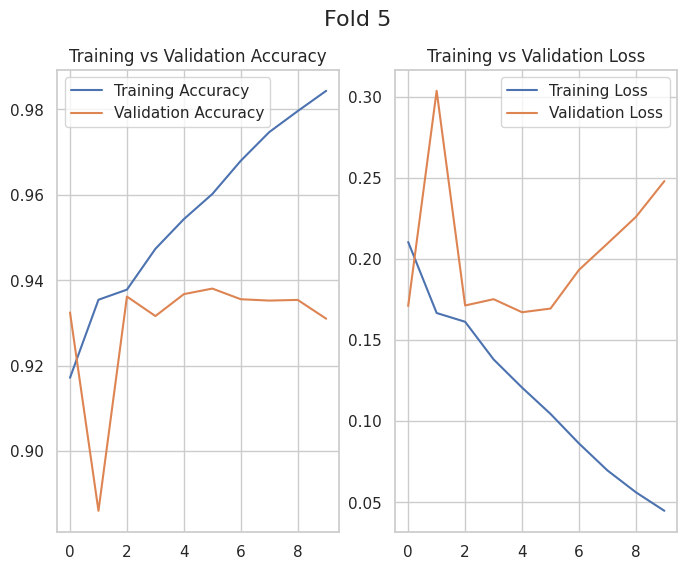

In [142]:
i = 1 # індексація як у fold

for acc, loss, history in zip(acc_per_fold, loss_per_fold,histories):

    plt.figure(figsize=(8, 6))
    plt.suptitle(f'Fold {i}', fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    print(f'Fold:{i}: Accuracy: {acc} --- Loss: {loss}')
    i+=1

In [143]:
y_pred = model.predict(X_test.text)
y_pred_bool = np.round(y_pred).astype(np.int64).squeeze(axis = 1)


1500/1500 [==============================] - 11s 5ms/step


In [144]:
classes = ['0','1']
report = classification_report(y_test, y_pred_bool, target_names=classes)

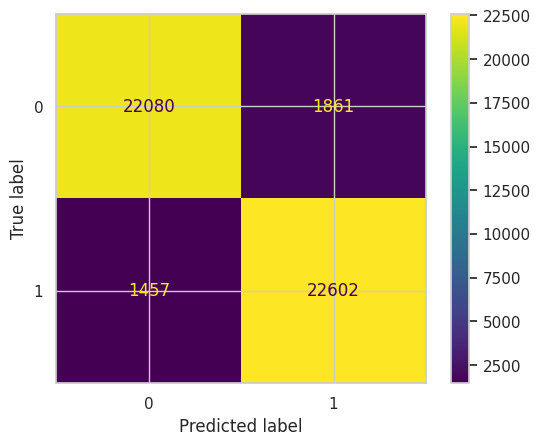

In [145]:
confusion_matrix = confusion_matrix(y_test, y_pred_bool)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes)
cm_display.plot()
plt.show()

In [147]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_bool)}")
print(report)

Accuracy: 0.930875
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     23941
           1       0.92      0.94      0.93     24059

    accuracy                           0.93     48000
   macro avg       0.93      0.93      0.93     48000
weighted avg       0.93      0.93      0.93     48000



In [151]:
test_set = pd.read_csv('test.csv')
y_pred = model.predict(test_set.text)
predicted_ID = test_set["id"]
predicted_test_bool = np.round(y_pred).astype(np.int64).squeeze(axis=1)
predicted_test_value = pd.DataFrame({ 'id': predicted_ID,
                        'humor': predicted_test_bool })
predicted_test_value
predicted_test_value.to_csv("PredictedTestScore.csv", index=False)

1250/1250 [==============================] - 9s 6ms/step
